## AJ_0065.8 - SCENIC - Network analysis

The aim here is to use the data generated from multiple SCENIC runs, all combined, to construct a network of connections between TFs and targets.  

#### PART 1
The first step is to create a table with STABLE network connections. In other words keep connections that appear in all 5 runs. Therefore, also remove TFs that do not have recurrent connections. [Python]. 
#### PART 2
The second step is to use this data to generate a network with all stable connections and subsequently look at how this network is changing during reprogramming. This can be done by for example projecting expression of tfs and targets in cells from different stages of reprogramming. To see which parts of network go off and which go on.

## PART 1 

### CONDA ENV - pySCENIC_2

In [1]:
import os
import glob
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pyscenic.rnkdb import FeatherRankingDatabase as RankingDatabase
from pyscenic.utils import modules_from_adjacencies, load_motifs
from pyscenic.prune import prune2df, df2regulons
from pyscenic.aucell import aucell

/data/leuven/320/vsc32023/miniconda/envs/pySCENIC_2/lib/python3.6/site-packages/dask/config.py:161: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


In [2]:
DATA_FOLDER="/staging/leuven/stg_00041/Adrian/TALON_JANISZEWSKI_XCR2/SCENIC/data_folder"

In [3]:
cd /staging/leuven/stg_00041/Adrian/TALON_JANISZEWSKI_XCR2/

/lustre1/project/stg_00041/Adrian/TALON_JANISZEWSKI_XCR2


Load in motif files from AJ_0065.5b

In [4]:
motifs1 = load_motifs(os.path.join(DATA_FOLDER, "motifs.csv"))
motifs2 = load_motifs(os.path.join(DATA_FOLDER, "motifs_2.csv"))
motifs3 = load_motifs(os.path.join(DATA_FOLDER, "motifs_3.csv"))
motifs4 = load_motifs(os.path.join(DATA_FOLDER, "motifs_4.csv"))
motifs5 = load_motifs(os.path.join(DATA_FOLDER, "motifs_5.csv"))

In [5]:
regulons_1 = df2regulons(motifs1)
regulons_2 = df2regulons(motifs2)
regulons_3 = df2regulons(motifs3)
regulons_4 = df2regulons(motifs4)
regulons_5 = df2regulons(motifs5)

##### Function: Convert regulons file into TF - target interaction table with two variables: TF and targets

In [6]:
# The function to convert raw regulon dictionary from pySCENIC to a dataframe with TF-target connections and co-expression weight that corresponds to each connection

# Input: regulons df directly from SCENIC (output of df2regulons(motifs1))
# Output is a data frame with variables: TF, Target, Weight (co-expression weight)

# The function repeats the similar operation twice, once to get TF - targets, and second to get weights. Then the two are merged to get TF-target-weight.
# The repetition is because I don't know how to 'explode' two list containing columns in data frame. In most recent version of Pandas it's possible, so that would
# simplify the function

def regulons2connections(regulons):

    #### Getting TF - Target list ####
    TF_target = []

    for tf in range(len(regulons)):
        connections = [regulons[tf].name, list(regulons[tf].gene2weight)] 
        TF_target.append(connections)

    # Create a data frame from the list with columns TF and Target (targets now are still in a list)

    TF_target = pd.DataFrame(TF_target, columns=['TF', 'Target'])

    # 'Explode' the listed targets so that now each row of the table contains a single interaction TF - target 
    #       (subfunction borrowed from internet. 'Explode' available in newer release of Pandas)

    lst_col = 'Target'

    TF_target_df_long = pd.DataFrame({
          col:np.repeat(TF_target[col].values, TF_target[lst_col].str.len())
          for col in TF_target.columns.drop(lst_col)}
        ).assign(**{lst_col:np.concatenate(TF_target[lst_col].values)})[TF_target.columns]

    #### Getting TF - Weight list == Same as above but for TFs and weights ####
    TF_weight = []

    for tf in range(len(regulons)):
        connections = [regulons[tf].name, list(regulons[tf].gene2weight.values())] 
        TF_weight.append(connections)

    TF_weight = pd.DataFrame(TF_weight, columns=['TF', 'Weight'])

    lst_col = 'Weight'

    TF_weight_df_long = pd.DataFrame({
          col:np.repeat(TF_weight[col].values, TF_weight[lst_col].str.len())
          for col in TF_weight.columns.drop(lst_col)}
        ).assign(**{lst_col:np.concatenate(TF_weight[lst_col].values)})[TF_weight.columns]    
    
    #### Merge TF_targets with TF_weight, to get TF_target_weight ####     
    TF_target_weight = pd.concat([TF_target_df_long, TF_weight_df_long['Weight']], axis=1)
    
    return TF_target_weight

Collect all connections from all runs in one data frame

In [7]:
all_runs = [regulons_1,regulons_2,regulons_3,regulons_4,regulons_5]

regulons_connections = pd.DataFrame()

for i in range(5):
    temp =  regulons2connections(all_runs[i])
    regulons_connections = regulons_connections.append(temp)

In [8]:
regulons_connections.to_csv('SCENIC/regulons_connections_weights.csv')

### CONDA ENV - R_base

In [1]:
library(readr)
library(tidyr)
library(dplyr)
library(purrr)
library(ggplot2)
#library(DESeq2)
library(ggrepel)
library(genefilter)
library(pheatmap)
library(tidygraph)
library(ggraph)
library(stringr)
library(tibble)
library(visNetwork)


Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


Attaching package: 'genefilter'

The following object is masked from 'package:readr':

    spec


Attaching package: 'tidygraph'

The following object is masked from 'package:stats':

    filter



In [2]:
setwd("/staging/leuven/stg_00041/Adrian/TALON_JANISZEWSKI_XCR2/")

In [3]:
all_connections <- read_csv('SCENIC/regulons_connections_weights.csv') 
all_connections <- all_connections[,-1]
all_connections$TF <- str_replace(all_connections$TF, "\\(\\+\\)", "")

Warning message:
"Missing column names filled in: 'X1' [1]"Parsed with column specification:
cols(
  X1 = col_integer(),
  TF = col_character(),
  Target = col_character(),
  Weight = col_double()
)


In [4]:
head(all_connections)
dim(all_connections)

TF,Target,Weight
2410141K09Rik,Cdk4,0.9817824
2410141K09Rik,Gtf2h1,17.7140512
2410141K09Rik,Sae1,13.0603468
2410141K09Rik,Apex1,11.7517344
2410141K09Rik,Dvl2,13.0603468
2410141K09Rik,Pop1,17.7140512


[1] 133913      3

#### Filter to keep only the connections that appeared in all 5 runs of SCENIC

In [5]:
all_robust_connections <- all_connections %>%
                                unite("TF_Target", TF, Target, sep = '_') %>%
                                group_by(TF_Target) %>%
                                add_count() %>%
                                filter(n == 5) %>% # Keep only the connection that appear in all runs
                                ungroup() %>%
                                separate(TF_Target, c("TF", "Target"), sep = "_") %>%
                                select(TF, Target, Weight)

In [6]:
length(unique(all_robust_connections$TF))
dim(all_robust_connections)

[1] 140

[1] 43090     3

#### Check the distribution of weight scores per connection

In [7]:
summary(all_robust_connections$Weight)

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
 0.01663  3.06292  6.42837  8.39192 11.78049 47.14832 

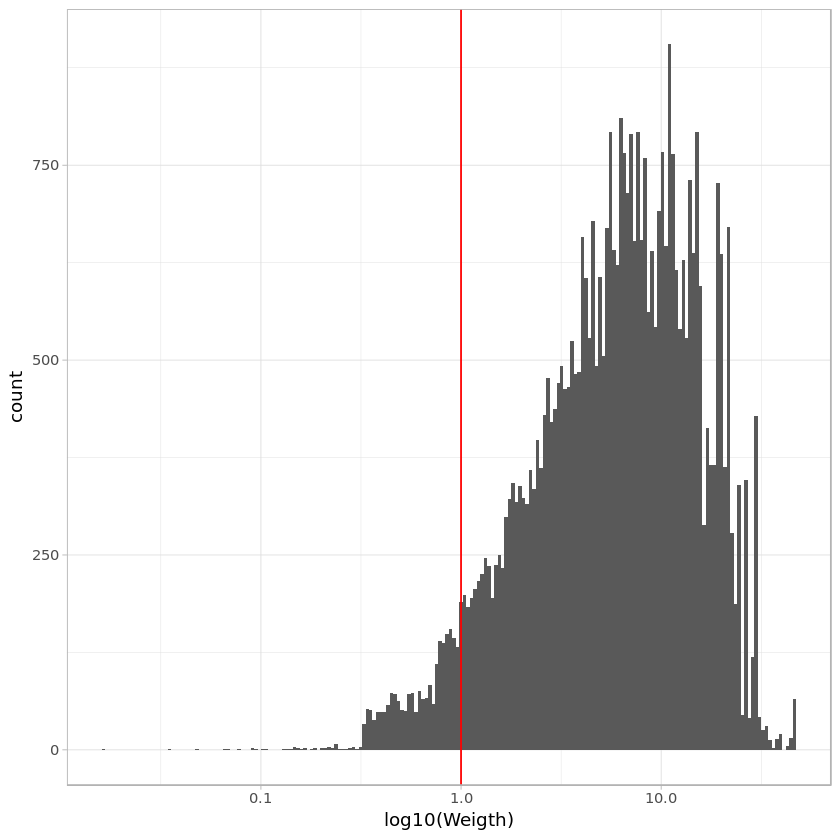

In [8]:
ggplot(all_robust_connections, aes(Weight)) +
geom_histogram(bins = 200) +
#xlim(0,10) +
geom_vline(xintercept=1, color = 'red') +
theme_light() +
scale_x_log10() +
xlab("log10(Weigth)")

In [9]:
table(all_robust_connections$Weight >= 1)

paste(as.character(round((2324/40746)*100,2)),"% of connections was removed.")


FALSE  TRUE 
 2324 40766 

[1] "5.7 % of connections was removed."

#### Apply the filter

In [10]:
all_robust_connections <- all_robust_connections %>%
                                filter(Weight >= 1)

#### Load and filter my main connections list (after 5 runs) to keep only robust connections

In [11]:
connections_5runs <- read_csv("SCENIC/regulons_targets.csv") # 311 REGULONS LIST OF CONNECTIONS (MAIN REGULONS)

Warning message:
"Missing column names filled in: 'X1' [1]"Parsed with column specification:
cols(
  X1 = col_integer(),
  Regulon = col_character(),
  Targets = col_character()
)


In [12]:
connections_5runs <- connections_5runs[,2:3]
connections_5runs$Regulon <- str_replace(connections_5runs$Regulon, "\\(\\+\\)", "")
colnames(connections_5runs) <- c("TF","Target")

In [13]:
head(connections_5runs)
dim(connections_5runs)
length(unique(connections_5runs$TF))
length(unique(connections_5runs$Target))

TF,Target
2410141K09Rik,Cdk4
2410141K09Rik,Gtf2h1
2410141K09Rik,Sae1
2410141K09Rik,Qtrt1
2410141K09Rik,Apex1
2410141K09Rik,Pop1


[1] 24156     2

[1] 311

[1] 8976

In [14]:
connections_5runs_filtered <- connections_5runs %>%
                                    semi_join(all_robust_connections, by = c("TF", "Target"))

In [15]:
head(connections_5runs_filtered)
dim(connections_5runs_filtered)
length(unique(connections_5runs_filtered$TF))
length(unique(connections_5runs_filtered$Target))

TF,Target
Arid3a,Adgrg1
Arid3a,Sbsn
Arid3a,Cldn4
Arid3a,Sertad2
Arid3a,Pdlim2
Arid3a,Clu


[1] 8614    2

[1] 140

[1] 4618

#### Remove three factors that are not part of the network (Gabpb1, Gsc - those interact only with each other, and Bmyc which interacts only with Ikzf2)

In [16]:
connections_5runs_filtered <- connections_5runs_filtered %>% filter(!(TF %in% c("Gabpb1","Gsc", "Bmyc")))

In [17]:
head(connections_5runs_filtered)
dim(connections_5runs_filtered)
length(unique(connections_5runs_filtered$TF))

TF,Target
Arid3a,Adgrg1
Arid3a,Sbsn
Arid3a,Cldn4
Arid3a,Sertad2
Arid3a,Pdlim2
Arid3a,Clu


[1] 8611    2

[1] 137

### Filter the regulons, to keep only those that are active in at least 10 cells

In [18]:
auc_mtx <- read.csv("SCENIC/auc_mtx_5.csv")

In [19]:
head(auc_mtx)

Cell,X2410141K09Rik...,Akr1a1...,Alx1...,Alx3...,Alx4...,Arid3a...,Arnt...,Atf3...,Atf4...,⋯,Zfp148...,Zfp362...,Zfp410...,Zfp42...,Zfp467...,Zfp667...,Zic3...,Zic5...,Zmiz1...,Zscan10...
Day_9_Xi_Mus_33,0.04189857,0.1412515,0,0,0,0.17659295,0.00000000,0.07668644,0.09558015,,0.00000000,0,0.0000000,0.06540736,0.07630722,0.04782211,0.0000000,0,0.075012198,0.08569761
Day_10_Xi_Mus_25,0.17300972,0.1295921,0,0,0,0.05630640,0.08029930,0.02993759,0.16795411,,0.01319862,0,0.0000000,0.11827622,0.00000000,0.11238005,0.0000000,0,0.007973111,0.15575260
Day_10_Xi_Mus_32,0.10660650,0.1295921,0,0,0,0.10619694,0.06599512,0.05396919,0.18447566,,0.00000000,0,0.0000000,0.08585769,0.00000000,0.12837342,0.0000000,0,0.031736208,0.12836103
Day_9_Xi_Mus_27,0.11266982,0.1293932,0,0,0,0.13793736,0.03021848,0.07551412,0.14347473,,0.03371463,0,0.0000000,0.09190361,0.00000000,0.03700477,0.0000000,0,0.039008209,0.11342516
Day_9_Xi_Mus_36,0.13542941,0.1290948,0,0,0,0.11177643,0.00000000,0.04981346,0.12447627,,0.00000000,0,0.1712373,0.08658987,0.07376799,0.06449128,0.0000000,0,0.023464786,0.16054179
Day_10_Xi_Mus_30,0.24870989,0.1293932,0,0,0,0.02614772,0.00000000,0.03021372,0.15539862,,0.02900200,0,0.0000000,0.18275565,0.05202173,0.08431324,0.1364037,0,0.009582028,0.21361607


In [20]:
colnames(auc_mtx) <- gsub('\\...','', colnames(auc_mtx)) # Remove the dots at the end

In [21]:
auc_mtx <- data.frame(auc_mtx[,-1], row.names = auc_mtx[,1])

In [22]:
auc_mtx_T <- t(auc_mtx)

In [23]:
head(auc_mtx_T)

,Day_9_Xi_Mus_33,Day_10_Xi_Mus_25,Day_10_Xi_Mus_32,Day_9_Xi_Mus_27,Day_9_Xi_Mus_36,Day_10_Xi_Mus_30,Day_10_Xi_Mus_33,Day_9_Xi_Mus_32,Day_10_Xi_Mus_34,Day_10_Xi_Mus_28,⋯,iPSCs_Xi_Mus_42,iPSCs_Xi_Mus_45,iPSCs_Xi_Mus_46,iPSCs_Xi_Mus_40,iPSCs_Xi_Mus_39,iPSCs_Xi_Mus_38,iPSCs_Xi_Mus_41,iPSCs_Xi_Mus_43,iPSCs_Xi_Mus_48,iPSCs_Xi_Mus_47
X2410141K09Rik,0.04189857,0.1730097,0.1066065,0.1126698,0.1354294,0.24870989,0.1104708,0.1376676,0.1405198,0.207175768,,0.30183685,0.20605619,0.27255571,0.313626873,0.311225269,0.253466862,0.305373230,0.3066469,0.26952744,0.30643780
Akr1a1,0.14125150,0.1295921,0.1295921,0.1293932,0.1290948,0.12939318,0.1277024,0.2502450,0.1335637,0.128995349,,0.12909481,0.12969155,0.12889589,0.128895892,0.128895892,0.177322419,0.129492632,0.1289953,0.12909481,0.12929372
Alx1,0.00000000,0.0000000,0.0000000,0.0000000,0.0000000,0.00000000,0.0000000,0.0000000,0.0000000,0.000000000,,0.00000000,0.05865873,0.00000000,0.000000000,0.000000000,0.000000000,0.000000000,0.0000000,0.00000000,0.00000000
Alx3,0.00000000,0.0000000,0.0000000,0.0000000,0.0000000,0.00000000,0.0000000,0.0000000,0.0000000,0.005523436,,0.00000000,0.00000000,0.00000000,0.000000000,0.000000000,0.000000000,0.000000000,0.0000000,0.00000000,0.00000000
Alx4,0.00000000,0.0000000,0.0000000,0.0000000,0.0000000,0.00000000,0.0000000,0.0000000,0.0000000,0.000000000,,0.00000000,0.00000000,0.00738797,0.000000000,0.000000000,0.000000000,0.000000000,0.0000000,0.00000000,0.00000000
Arid3a,0.17659295,0.0563064,0.1061969,0.1379374,0.1117764,0.02614772,0.1426922,0.1623219,0.1668901,0.110459134,,0.01108922,0.01642074,0.01264046,0.003818799,0.006898768,0.009666428,0.009332876,0.0065530,0.00422476,0.00896908


#### Count number of cells in which each regulon is active and filter

In [24]:
# Function count number of cells with AUC > 0.05

count_active <- function(vector){
  length(vector[vector>0.05])  
}

In [25]:
auc_mtx_T_df <- as.data.frame(auc_mtx_T)

In [26]:
# Apply function to the AUC matrix by rows

active_in_n_cells <- lapply(1:nrow(auc_mtx_T_df), function(r_num) { count_active(auc_mtx_T_df[r_num, ]) })
active_in_n_cells <- do.call(rbind, active_in_n_cells)[,1]

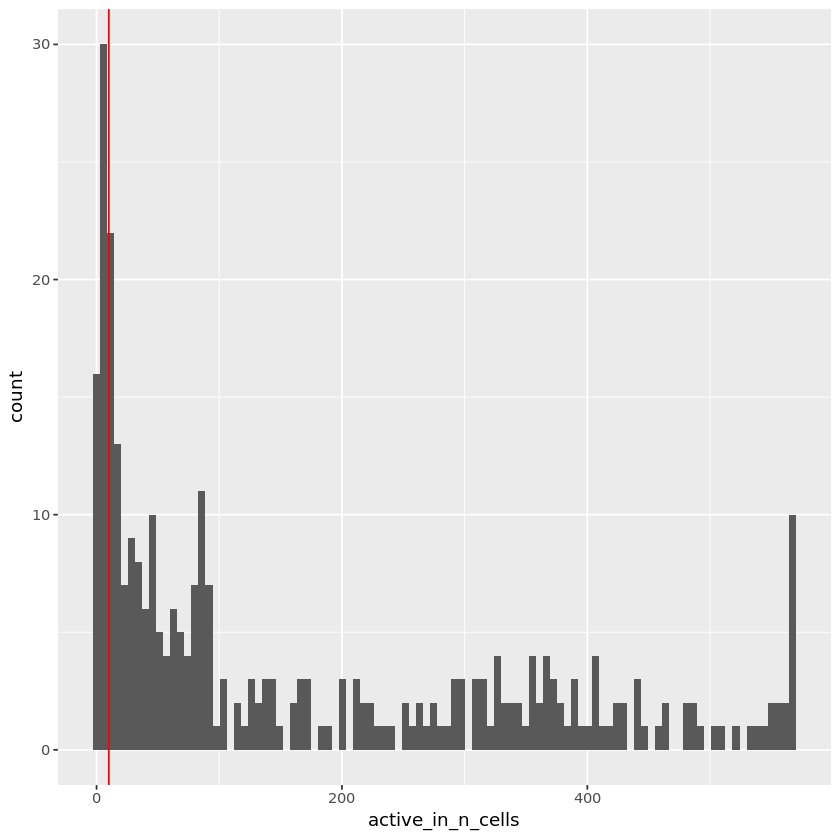

In [27]:
# Check the number of cells in which regulons are active

ggplot() +
geom_histogram(aes(active_in_n_cells), bins = 100)+
geom_vline(xintercept = 10, color = 'red') 

In [28]:
# Check which regulons would be removed. Useful to make sure and look them up on tSNEs.

TFs_to_remove <- rownames(auc_mtx_T_df)[which(active_in_n_cells<10)]
TFs_to_remove

[1] "Alx3"    "Alx4"    "Bach2"   "Batf"    "Creb5"   "Dmbx1"   "Egr4"   
 [8] "Esr1"    "Esrra"   "Foxf1"   "Foxf2"   "Foxj1"   "Foxj3"   "Gata3"  
[15] "Gm45871" "Hes7"    "Hey1"    "Hey2"    "Hoxa11"  "Hoxa13"  "Hoxa3"  
[22] "Hoxb5"   "Hoxb6"   "Hoxd8"   "Hoxd9"   "Irf5"    "Irf8"    "Lhx2"   
[29] "Meox1"   "Mixl1"   "Nkx3.."  "Nkx6.."  "Npas2"   "Nr1h3"   "Nr2f6"  
[36] "Pax9"    "Pknox2"  "Pou1f1"  "Rfx3"    "Rfx4"    "Sox21"   "Sox5"   
[43] "Spi1"    "Stat1"   "Tal1"    "Tbx2"    "Tbx5"    "Tbx6"    "Tcf24"  
[50] "Tfap2b"  "Usf2"    "Vdr"     "Zfp362"

In [29]:
# Filter out those regulons

connections_5runs_filtered_active <- connections_5runs_filtered %>%
                                        filter(!(TF %in% TFs_to_remove))

In [30]:
head(connections_5runs_filtered_active)
dim(connections_5runs_filtered_active)
length(unique(connections_5runs_filtered_active$TF))

TF,Target
Arid3a,Adgrg1
Arid3a,Sbsn
Arid3a,Cldn4
Arid3a,Sertad2
Arid3a,Pdlim2
Arid3a,Clu


[1] 8263    2

[1] 123

#### The above step removed only 14 regulons

### ADD THE SCALED EXPRESSION WITHIN EACH STATE

The goal here is to compare how expression of the network changes in three different states identified by SCENIC; somatic, intermediate and pluripotent.  
I will take the scaled gene expression from SEURAT together with the information about clusters 0 for somatic, (1,2,3) for intermediate and (4,5) for pluripotent.  
    Next I will group within those clusters and summarize with the mean. So now each gene has the expression value for each state.  
    Next I will add this information to the network (expr_somatic, expr_inter, expr_pluri)

In [46]:
seurat_clusters <- read.csv("monocle/pseudotime_cluster_gene_normExpr.csv")

In [52]:
seurat_clusters <- seurat_clusters %>% 
                    select(Name, seurat_clusters_rename) %>%
                    distinct(Name, .keep_all = TRUE) 

#### IMPORT SCALED DATA DIRECTLY FROM SEURAT OBJECT

In [ ]:
# seurat[["RNA"]]@scale.data

In [31]:
counts_scaled <- read.csv("seurat/seurat_scaled.csv")
counts_scaled <- data.frame(counts_scaled[,-1], row.names = counts_scaled$X)

In [34]:
head(counts_scaled)

,Day_9_Xi_Mus_33,Day_10_Xi_Mus_25,Day_10_Xi_Mus_32,Day_9_Xi_Mus_27,Day_9_Xi_Mus_36,Day_10_Xi_Mus_30,Day_10_Xi_Mus_33,Day_9_Xi_Mus_32,Day_10_Xi_Mus_34,Day_10_Xi_Mus_28,⋯,iPSCs_Xi_Mus_42,iPSCs_Xi_Mus_45,iPSCs_Xi_Mus_46,iPSCs_Xi_Mus_40,iPSCs_Xi_Mus_39,iPSCs_Xi_Mus_38,iPSCs_Xi_Mus_41,iPSCs_Xi_Mus_43,iPSCs_Xi_Mus_48,iPSCs_Xi_Mus_47
Gm37363,-0.05154006,-0.05154006,-0.05154006,-0.05154006,-0.05154006,-0.05154006,-0.05154006,-0.05154006,-0.05154006,-0.05154006,,-0.05154006,-0.05154006,-0.05154006,-0.05154006,-0.05154006,-0.05154006,-0.05154006,-0.05154006,-0.05154006,-0.05154006
Gm19938,-0.06318326,-0.06318326,-0.06318326,-0.06318326,-0.06318326,-0.06318326,-0.06318326,-0.06318326,-0.06318326,-0.06318326,,-0.06318326,-0.06318326,-0.06318326,-0.06318326,-0.06318326,-0.06318326,-0.06318326,-0.06318326,-0.06318326,-0.06318326
Gm37381,-0.20643892,-0.20643892,-0.20643892,6.88049037,-0.20643892,-0.20643892,-0.20643892,-0.20643892,-0.20643892,-0.20643892,,-0.20643892,-0.20643892,3.30035235,-0.20643892,-0.20643892,-0.20643892,-0.20643892,-0.20643892,-0.20643892,-0.20643892
Gm6101,2.69090429,-0.21405793,-0.21405793,-0.21405793,-0.21405793,-0.21405793,-0.21405793,-0.21405793,-0.21405793,-0.21405793,,-0.21405793,-0.21405793,-0.21405793,-0.21405793,-0.21405793,1.01780675,-0.21405793,-0.21405793,-0.21405793,-0.21405793
Sox17,-0.06371262,-0.06371262,-0.06371262,-0.06371262,-0.06371262,-0.06371262,-0.06371262,-0.06371262,-0.06371262,-0.06371262,,-0.06371262,-0.06371262,-0.06371262,-0.06371262,-0.06371262,-0.06371262,5.00484697,-0.06371262,-0.06371262,-0.06371262
Gm7357,-0.44025291,-0.44025291,-0.44025291,-0.44025291,-0.44025291,-0.44025291,2.11324206,-0.44025291,1.43607302,1.71516847,,-0.44025291,0.47586969,-0.44025291,-0.44025291,-0.44025291,0.65461659,0.22181025,0.36425838,-0.44025291,-0.44025291


In [37]:
counts_scaled_t1 <- as.data.frame(t(counts_scaled))
head(counts_scaled_t1)

ERROR while rich displaying an object: Error in sprintf(wrap, header, body): 'fmt' length exceeds maximal format length 8192

Traceback:
1. FUN(X[[i]], ...)
2. tryCatch(withCallingHandlers({
 .     rpr <- mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)
3. tryCatchList(expr, classes, parentenv, handlers)
4. tryCatchOne(expr, names, parentenv, handlers[[1L]])
5. doTryCatch(return(expr), name, parentenv, handler)
6. withCallingHandlers({
 .     rpr <- mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler)
7. mime2repr[[mime]](obj)
8. repr_latex.data.frame(obj)
9. repr_matrix_generic(obj, sprintf("\\begin{tabular}{%s}\n%%s%%s\\end{tabular}\n", 
 .     cols), "%s\\\\\n\\hline\n", "  &", " %s &", "%s", "\t%s\\\\\n", 
 .     "%s &", " %s &", escape_fun = latex_escape_vec, ...)
10. sprintf(

,Gm37363,Gm19938,Gm37381,Gm6101,Sox17,Gm7357,Gm7369,Gm6085,Gm2053,Gm6123,⋯,mt-Nd4,mt-Ts2,mt-Tl2,mt-Nd5,mt-Nd6,mt-Te,mt-Cytb,mt-Tt,mt-Tp,pCX-eGFP
Day_9_Xi_Mus_33,-0.05154006,-0.06318326,-0.2064389,2.6909043,-0.06371262,-0.4402529,-0.1167997,-0.6906644,-0.07245099,-0.5550123,,0.2647002,-0.2283588,-0.2966698,0.5223387,0.1581316,-0.1831701,-1.3040578,-0.24257533,-0.6602651,-0.5729165
Day_10_Xi_Mus_25,-0.05154006,-0.06318326,-0.2064389,-0.2140579,-0.06371262,-0.4402529,-0.1167997,-1.0951444,-0.07245099,-0.5550123,,0.2264778,-0.2283588,-0.2966698,0.7455967,0.4521007,-0.1831701,-0.9481857,-0.87608691,-0.3919177,-0.5729165
Day_10_Xi_Mus_32,-0.05154006,-0.06318326,-0.2064389,-0.2140579,-0.06371262,-0.4402529,-0.1167997,1.0207909,-0.07245099,1.0753504,,-1.3850378,-0.2283588,-0.2966698,-2.0853767,-1.4020854,-0.1831701,-1.5952828,-0.37536461,-1.0186553,-0.5729165
Day_9_Xi_Mus_27,-0.05154006,-0.06318326,6.8804904,-0.2140579,-0.06371262,-0.4402529,-0.1167997,-0.5097732,-0.07245099,-0.5550123,,-0.6884502,-0.2283588,-0.2966698,-0.9180080,-0.7080211,-0.1831701,-1.1434587,0.89025516,-0.2287020,-0.5729165
Day_9_Xi_Mus_36,-0.05154006,-0.06318326,-0.2064389,-0.2140579,-0.06371262,-0.4402529,-0.1167997,-1.0951444,-0.07245099,-0.5550123,,2.5136262,-0.2283588,-0.2966698,1.9902700,1.8690474,-0.1831701,1.8662977,0.44033668,1.4360096,-0.5729165
Day_10_Xi_Mus_30,-0.05154006,-0.06318326,-0.2064389,-0.2140579,-0.06371262,-0.4402529,-0.1167997,-0.7807222,-0.07245099,-0.5550123,,-0.3874184,-0.2283588,-0.2966698,0.1691001,-1.5549826,-0.1831701,-0.3728808,0.09387658,-0.6443212,0.1066036


In [38]:
indx <- sapply(counts_scaled_t, is.factor)
counts_scaled_t1[indx] <- lapply(counts_scaled_t[indx], function(x) as.numeric(as.character(x)))

In [39]:
counts_scaled_t1$Name <- rownames(counts_scaled_t)

In [40]:
head(counts_scaled_t1)

ERROR while rich displaying an object: Error in sprintf(wrap, header, body): 'fmt' length exceeds maximal format length 8192

Traceback:
1. FUN(X[[i]], ...)
2. tryCatch(withCallingHandlers({
 .     rpr <- mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)
3. tryCatchList(expr, classes, parentenv, handlers)
4. tryCatchOne(expr, names, parentenv, handlers[[1L]])
5. doTryCatch(return(expr), name, parentenv, handler)
6. withCallingHandlers({
 .     rpr <- mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler)
7. mime2repr[[mime]](obj)
8. repr_latex.data.frame(obj)
9. repr_matrix_generic(obj, sprintf("\\begin{tabular}{%s}\n%%s%%s\\end{tabular}\n", 
 .     cols), "%s\\\\\n\\hline\n", "  &", " %s &", "%s", "\t%s\\\\\n", 
 .     "%s &", " %s &", escape_fun = latex_escape_vec, ...)
10. sprintf(

,Gm37363,Gm19938,Gm37381,Gm6101,Sox17,Gm7357,Gm7369,Gm6085,Gm2053,Gm6123,⋯,mt-Ts2,mt-Tl2,mt-Nd5,mt-Nd6,mt-Te,mt-Cytb,mt-Tt,mt-Tp,pCX-eGFP,Name
Day_9_Xi_Mus_33,-0.05154006,-0.06318326,-0.2064389,2.6909043,-0.06371262,-0.4402529,-0.1167997,-0.6906644,-0.07245099,-0.5550123,,-0.2283588,-0.2966698,0.5223387,0.1581316,-0.1831701,-1.3040578,-0.24257533,-0.6602651,-0.5729165,Day_9_Xi_Mus_33
Day_10_Xi_Mus_25,-0.05154006,-0.06318326,-0.2064389,-0.2140579,-0.06371262,-0.4402529,-0.1167997,-1.0951444,-0.07245099,-0.5550123,,-0.2283588,-0.2966698,0.7455967,0.4521007,-0.1831701,-0.9481857,-0.87608691,-0.3919177,-0.5729165,Day_10_Xi_Mus_25
Day_10_Xi_Mus_32,-0.05154006,-0.06318326,-0.2064389,-0.2140579,-0.06371262,-0.4402529,-0.1167997,1.0207909,-0.07245099,1.0753504,,-0.2283588,-0.2966698,-2.0853767,-1.4020854,-0.1831701,-1.5952828,-0.37536461,-1.0186553,-0.5729165,Day_10_Xi_Mus_32
Day_9_Xi_Mus_27,-0.05154006,-0.06318326,6.8804904,-0.2140579,-0.06371262,-0.4402529,-0.1167997,-0.5097732,-0.07245099,-0.5550123,,-0.2283588,-0.2966698,-0.9180080,-0.7080211,-0.1831701,-1.1434587,0.89025516,-0.2287020,-0.5729165,Day_9_Xi_Mus_27
Day_9_Xi_Mus_36,-0.05154006,-0.06318326,-0.2064389,-0.2140579,-0.06371262,-0.4402529,-0.1167997,-1.0951444,-0.07245099,-0.5550123,,-0.2283588,-0.2966698,1.9902700,1.8690474,-0.1831701,1.8662977,0.44033668,1.4360096,-0.5729165,Day_9_Xi_Mus_36
Day_10_Xi_Mus_30,-0.05154006,-0.06318326,-0.2064389,-0.2140579,-0.06371262,-0.4402529,-0.1167997,-0.7807222,-0.07245099,-0.5550123,,-0.2283588,-0.2966698,0.1691001,-1.5549826,-0.1831701,-0.3728808,0.09387658,-0.6443212,0.1066036,Day_10_Xi_Mus_30


In [53]:
counts_scaled_t2 <- counts_scaled_t1 %>%
                    left_join(seurat_clusters, by = "Name")

Warning message:
"Column `Name` joining character vector and factor, coercing into character vector"

In [54]:
head(counts_scaled_t2)

ERROR while rich displaying an object: Error in sprintf(wrap, header, body): 'fmt' length exceeds maximal format length 8192

Traceback:
1. FUN(X[[i]], ...)
2. tryCatch(withCallingHandlers({
 .     rpr <- mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)
3. tryCatchList(expr, classes, parentenv, handlers)
4. tryCatchOne(expr, names, parentenv, handlers[[1L]])
5. doTryCatch(return(expr), name, parentenv, handler)
6. withCallingHandlers({
 .     rpr <- mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler)
7. mime2repr[[mime]](obj)
8. repr_latex.data.frame(obj)
9. repr_matrix_generic(obj, sprintf("\\begin{tabular}{%s}\n%%s%%s\\end{tabular}\n", 
 .     cols), "%s\\\\\n\\hline\n", "  &", " %s &", "%s", "\t%s\\\\\n", 
 .     "%s &", " %s &", escape_fun = latex_escape_vec, ...)
10. sprintf(

Gm37363,Gm19938,Gm37381,Gm6101,Sox17,Gm7357,Gm7369,Gm6085,Gm2053,Gm6123,⋯,mt-Tl2,mt-Nd5,mt-Nd6,mt-Te,mt-Cytb,mt-Tt,mt-Tp,pCX-eGFP,Name,seurat_clusters_rename
-0.05154006,-0.06318326,-0.2064389,2.6909043,-0.06371262,-0.4402529,-0.1167997,-0.6906644,-0.07245099,-0.5550123,,-0.2966698,0.5223387,0.1581316,-0.1831701,-1.3040578,-0.24257533,-0.6602651,-0.5729165,Day_9_Xi_Mus_33,1
-0.05154006,-0.06318326,-0.2064389,-0.2140579,-0.06371262,-0.4402529,-0.1167997,-1.0951444,-0.07245099,-0.5550123,,-0.2966698,0.7455967,0.4521007,-0.1831701,-0.9481857,-0.87608691,-0.3919177,-0.5729165,Day_10_Xi_Mus_25,2
-0.05154006,-0.06318326,-0.2064389,-0.2140579,-0.06371262,-0.4402529,-0.1167997,1.0207909,-0.07245099,1.0753504,,-0.2966698,-2.0853767,-1.4020854,-0.1831701,-1.5952828,-0.37536461,-1.0186553,-0.5729165,Day_10_Xi_Mus_32,2
-0.05154006,-0.06318326,6.8804904,-0.2140579,-0.06371262,-0.4402529,-0.1167997,-0.5097732,-0.07245099,-0.5550123,,-0.2966698,-0.9180080,-0.7080211,-0.1831701,-1.1434587,0.89025516,-0.2287020,-0.5729165,Day_9_Xi_Mus_27,1
-0.05154006,-0.06318326,-0.2064389,-0.2140579,-0.06371262,-0.4402529,-0.1167997,-1.0951444,-0.07245099,-0.5550123,,-0.2966698,1.9902700,1.8690474,-0.1831701,1.8662977,0.44033668,1.4360096,-0.5729165,Day_9_Xi_Mus_36,2
-0.05154006,-0.06318326,-0.2064389,-0.2140579,-0.06371262,-0.4402529,-0.1167997,-0.7807222,-0.07245099,-0.5550123,,-0.2966698,0.1691001,-1.5549826,-0.1831701,-0.3728808,0.09387658,-0.6443212,0.1066036,Day_10_Xi_Mus_30,4


In [56]:
counts_scaled_t2_long <- counts_scaled_t2 %>%
                                select(-Name) %>%
                                gather(gene, expression,-seurat_clusters_rename) %>%
                                mutate(scenic_state = case_when(
                                                            seurat_clusters_rename == "0" ~ "somatic",
                                                            seurat_clusters_rename %in% c("1", "2", "3") ~ "intermediate",
                                                            seurat_clusters_rename %in% c("4","5") ~ "pluripotency")) %>%
                                group_by(scenic_state, gene) %>%
                                summarize(mean_expression = mean(expression)) %>%
                                ungroup()

In [57]:
head(counts_scaled_t2_long)

scenic_state,gene,mean_expression
intermediate,0610005C13Rik,-0.1401220290
intermediate,0610009B22Rik,0.0261726822
intermediate,0610009E02Rik,-0.0329694580
intermediate,0610009L18Rik,-0.0457878814
intermediate,0610009O20Rik,0.1548098686
intermediate,0610010F05Rik,0.0009555432


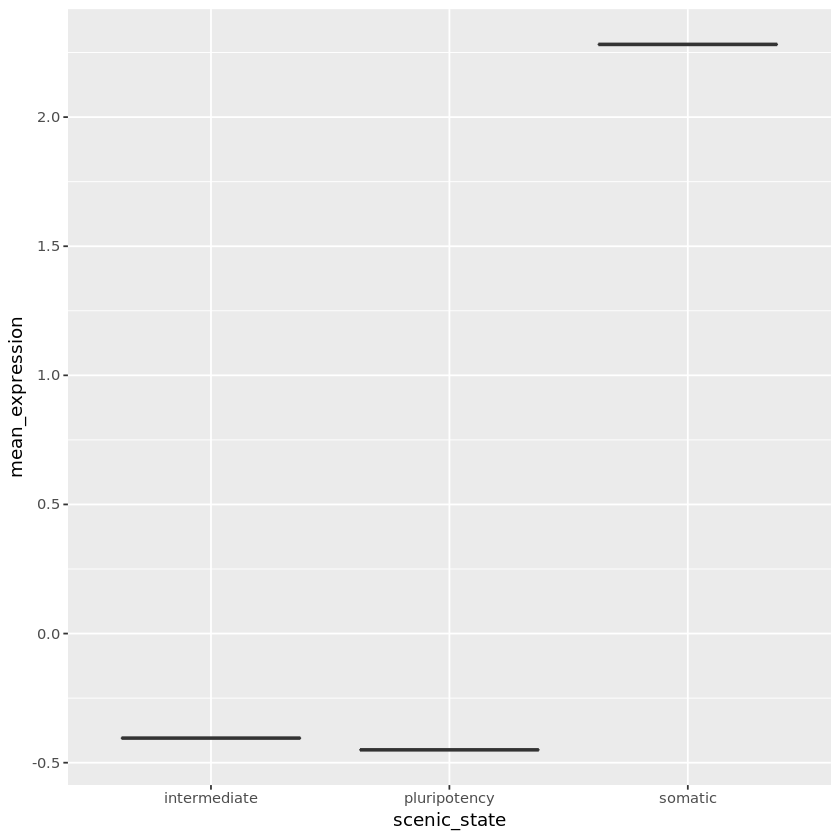

In [59]:
counts_scaled_t2_long %>% 
            filter(gene == "Col1a1") %>%
            ggplot(., aes(scenic_state, mean_expression)) +
                geom_boxplot()

In [60]:
counts_scaled_t2_long <- counts_scaled_t2_long %>%
    spread(scenic_state, mean_expression)

In [61]:
head(counts_scaled_t2_long)

gene,intermediate,pluripotency,somatic
0610005C13Rik,-0.1401220290,0.31738223,-0.09529591
0610009B22Rik,0.0261726822,0.17271654,-0.39391861
0610009E02Rik,-0.0329694580,-0.07170767,0.23793637
0610009L18Rik,-0.0457878814,-0.02978747,0.09253778
0610009O20Rik,0.1548098686,-0.07212381,-0.45326070
0610010F05Rik,0.0009555432,-0.14342010,0.24253428


In [62]:
filter(counts_scaled_t2_long, gene == "Col1a1")

gene,intermediate,pluripotency,somatic
Col1a1,-0.4048776,-0.4501511,2.281508


# PART TWO

## GENERATE NETWORK

### Create nodes

In [63]:
TFs <- connections_5runs_filtered_active %>%
                select(TF) %>%
                rename(label = TF) %>%
                filter(!duplicated(.$label))

In [64]:
head(TFs)

label
Arid3a
Atf3
Atf4
Atf6b
Barx1
Bcl6


In [65]:
targets <- connections_5runs_filtered_active %>%
                select(Target) %>%
                rename(label = Target) %>%
                filter(!duplicated(.$label))

In [66]:
nodes <- full_join(TFs, targets, by = c('label'))

In [67]:
nodes <- nodes %>% rowid_to_column("id")
head(nodes)

id,label
1,Arid3a
2,Atf3
3,Atf4
4,Atf6b
5,Barx1
6,Bcl6


Combine nodes with gene expression

In [68]:
nodes <- nodes %>%
            rename(gene = label) %>%
            left_join(counts_scaled_t2_long, by = 'gene') %>%
            rename(label = gene)

In [69]:
head(nodes)

id,label,intermediate,pluripotency,somatic
1,Arid3a,0.26086467,-0.3658604,-0.34453064
2,Atf3,0.18871350,-0.3689751,-0.07025901
3,Atf4,-0.20642217,0.3786784,0.11961397
4,Atf6b,-0.20894679,0.2967940,0.26953009
5,Barx1,0.06343997,-0.2264398,0.14334252
6,Bcl6,-0.06848822,-0.3665439,0.88423023


In [70]:
dim(nodes)

[1] 4419    5

In [71]:
nodes$label[which(duplicated(nodes$label))]

character(0)

### Create edges

In [72]:
edges <- connections_5runs_filtered_active %>% 
  left_join(nodes, by = c("TF" = "label")) %>% 
  rename(from = id)

edges <- edges %>% 
  left_join(nodes, by = c("Target" = "label")) %>% 
  rename(to = id)

In [73]:
head(edges)

TF,Target,from,intermediate.x,pluripotency.x,somatic.x,to,intermediate.y,pluripotency.y,somatic.y
Arid3a,Adgrg1,1,0.2608647,-0.3658604,-0.3445306,124,0.2047546,-0.2230913,-0.3803718
Arid3a,Sbsn,1,0.2608647,-0.3658604,-0.3445306,125,0.2979134,-0.4398324,-0.3556918
Arid3a,Cldn4,1,0.2608647,-0.3658604,-0.3445306,126,0.6652790,-0.6856023,-1.3032449
Arid3a,Sertad2,1,0.2608647,-0.3658604,-0.3445306,127,0.1796071,-0.4681896,0.1339260
Arid3a,Pdlim2,1,0.2608647,-0.3658604,-0.3445306,128,0.2159863,-0.5974494,0.2201291
Arid3a,Clu,1,0.2608647,-0.3658604,-0.3445306,129,0.3712355,-0.4830664,-0.5547980


In [74]:
edges <- edges %>%
            select(from, to)
            
head(edges)

from,to
1,124
1,125
1,126
1,127
1,128
1,129


### Create a tidygraph object

In [75]:
GRNs <- tbl_graph(nodes = nodes, edges = edges, directed = TRUE) 

In [76]:
#GRNs <- GRNs %>% 
#                  activate(edges) %>% 
#                 arrange(desc(weight)) %>%
#                   filter(weight > 0) %>%
#                   activate(nodes) %>%
#                   filter(no_edges > 100)
GRNs <- GRNs %>%
activate(nodes) %>% 
  mutate(degree  = centrality_degree())
GRNs

# A tbl_graph: 4419 nodes and 8263 edges
#
# A directed multigraph with 1 component
#
# Node Data: 4,419 x 6 (active)
     id label  intermediate pluripotency somatic degree
  <int> <chr>         <dbl>        <dbl>   <dbl>  <dbl>
1     1 Arid3a       0.261        -0.366 -0.345      55
2     2 Atf3         0.189        -0.369 -0.0703    140
3     3 Atf4        -0.206         0.379  0.120      85
4     4 Atf6b       -0.209         0.297  0.270       5
5     5 Barx1        0.0634       -0.226  0.143       4
6     6 Bcl6        -0.0685       -0.367  0.884      12
# ... with 4,413 more rows
#
# Edge Data: 8,263 x 2
   from    to
  <int> <int>
1     1   124
2     1   125
3     1   126
# ... with 8,260 more rows

In [77]:
net <- ggraph(GRNs, layout = 'stress', bbox = 20, niter = 500) + 
  
  geom_edge_fan(alpha = 0.5) + 
  scale_edge_width(range = c(2, 4)) +
  geom_node_point(aes(size = degree, color = pluripotency), show.legend = T) +
  #geom_node_text(aes(label = label), color = 'black', repel = FALSE, size = 20) +
  #geom_node_text(aes(label = ifelse(degree > 50, label, NA)), color = 'black', repel = FALSE, size = 40) +
  scale_size(range = c(10,200))+
  labs(edge_width = "GRNs") +
  #scale_colour_gradient2(low = "blue", mid = "wheat1", high = "red", midpoint = 0) +
  scale_color_viridis(option = "plasma") +
  theme_graph(base_family = "Times")


When exporting the networks remember that they are very very big, so it takes time and space.  

In [708]:
pdf("SCENIC/GRNs_SCENIC_robust_all_filtered_active_expr_pluripotency_seurat_scaled_3_nolabel.pdf", width = 170, height = 150)
plot(net)
dev.off()

png 
  2

In [689]:
dev.off()

pdf 
  3

In [690]:
jpeg("SCENIC/GRN_somatic.jpeg", width = 10000, height = 10000, res = 1000)
plot(net)
dev.off()

Warning message:
"Removed 4374 rows containing missing values (geom_text)."

png 
  2